<h1> Yelp rating predictor </h1>

Import the modules that I'll be using and change some pandas settings to make the large dataframe more readible

In [28]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
pd.options.display.max_columns = 60
pd.options.display.max_colwidth = 500

Importing the yelp data for different resturants

In [29]:
businesses = pd.read_json('yelp_business.json',lines=True)
reviews = pd.read_json('yelp_review.json',lines=True)
users = pd.read_json('yelp_user.json',lines=True)
checkins = pd.read_json('yelp_checkin.json',lines=True)
tips = pd.read_json('yelp_tip.json',lines=True)
photos = pd.read_json('yelp_photo.json',lines=True)

Merging the dataframes on business_id starting from the reviews as thats what I am assesing. <br>
I then remove the features not required and fill any Nan values with 0 as LinearRegression will not work with Nan values. <br>
A correlation matrix is made between each of the remaining features and sorted to find the features most correlated to the number of stars a restaurant has.

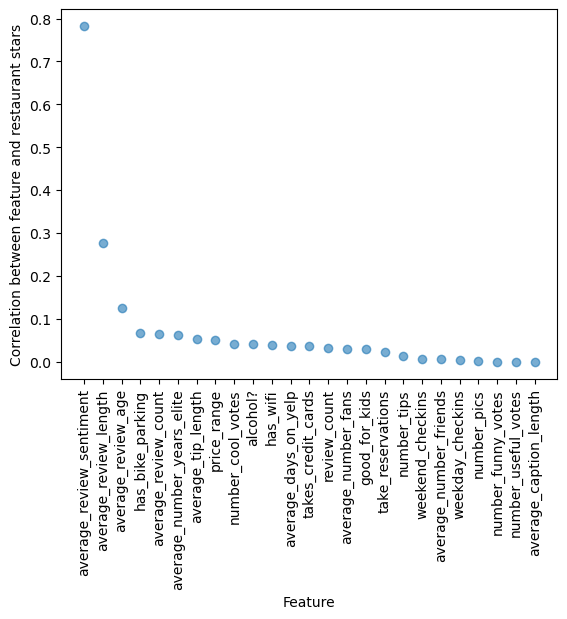

<Figure size 1200x1200 with 0 Axes>

In [94]:
dataframe = businesses.merge(reviews, how='left', on='business_id').merge(users, how='left', on='business_id').merge(checkins, how='left', on='business_id').merge(tips, how='left', on='business_id').merge(photos, how='left', on='business_id')
features_to_remove = ['address','attributes','business_id','categories','city','hours','is_open','latitude','longitude','name','neighborhood','postal_code','state','time']
dataframe.drop(features_to_remove, axis=1, inplace=True)
dataframe.fillna(0,inplace=True)
dataframe_correlation_matrix = dataframe.corr()
sorted_matrix = dataframe_correlation_matrix.stars.abs().sort_values(ascending = False).reset_index()
sorted_matrix.drop(index=[0],inplace=True)
sorted_matrix.reset_index()
plt.scatter(sorted_matrix["index"], sorted_matrix["stars"], alpha=0.6)
plt.ylabel("Correlation between feature and restaurant stars")
plt.xlabel("Feature")
plt.xticks(rotation = 90)
plt.figure(figsize = (12,12))
plt.show()

I then create a function that takes the features you want to correlate with the yelp review and the dataframe as arguments. The data is split into a training and testing set in a 5:1ratio and a linear regression model is fitted to the training set and tested on the test set. The function prints the accuracy of the model as well as a graph of test ratings versus predicted.

In [181]:
def model_these_features(feature_list,dataframework):
    ratings = dataframework["stars"]
    features = dataframework[feature_list]
    X_train, X_test, Y_train, Y_test = train_test_split(features, ratings, test_size=0.2, random_state = 1)
    global linreg
    linreg = LinearRegression()
    linreg.fit(X_train.values,Y_train.values)
    y_predicted = linreg.predict(X_test.values)

    plt.scatter(Y_test.values,y_predicted, marker = "x")
    plt.plot(range(7),range(7))
    plt.xlim(0,5.5)
    plt.ylim(0,5.5)
    plt.xlabel("Actual resturant review scores")
    plt.ylabel("Predicted resturant review scores")
    if len(feature_list) < 3:
        plt.title("Review score predictor from {}".format(feature_list))
    else:
        print("Review score predictor from {}".format(feature_list))
    plt.figure(figsize = (12,12))
    plt.show()
    print("Score: {}".format(linreg.score(X_test.values,Y_test.values)))

I select the top 2 correlated features (not including "average_review_sentiment") as found from the correlation matrix. This gives me an accuracy score of 0.0823 which is quite low.

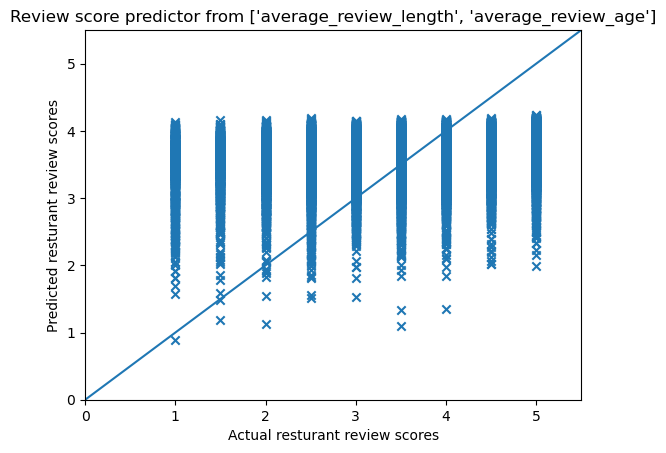

<Figure size 1200x1200 with 0 Axes>

Score: 0.08083081210060561


In [182]:
features = ["average_review_length","average_review_age"]
model_these_features(features,dataframe)

When I use every column in the feaure list to predict the yelp rating, I produce a much better score of 0.68. The graph shows that this is still a weak correlation but sufficient for predictive purposes.

Review score predictor from ['average_review_sentiment', 'average_review_length', 'average_review_age', 'has_bike_parking', 'average_review_count', 'average_number_years_elite', 'average_tip_length', 'price_range', 'number_cool_votes', 'alcohol?', 'has_wifi', 'average_days_on_yelp', 'takes_credit_cards', 'review_count', 'average_number_fans', 'good_for_kids', 'take_reservations', 'number_tips', 'weekend_checkins', 'average_number_friends', 'weekday_checkins', 'number_pics', 'number_funny_votes', 'number_useful_votes', 'average_caption_length']


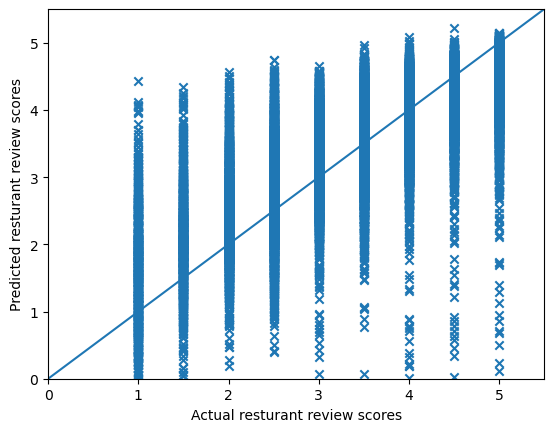

<Figure size 1200x1200 with 0 Axes>

Score: 0.6782129045869246


In [183]:
model_these_features(list(sorted_matrix["index"]),dataframe)

I then use this model to predict the yelp rating for an unknown resturant

In [193]:
danielles_delicious_delicacies = np.array([0.9,1200.0,10.0,1.0,123.0,0.5,50.0,2.0,6.0,0.0,1.0,1800.0,1.0,10.0,12.0,1.0,1.0,3.0,0.0,50.0,0.0,10.0,3.0,5.0,3.0]).reshape(1,-1)
print("I predict Danielle's Delicious Delicacies will have a yelp rating of : {}".format(int(linreg.predict(danielles_delicious_delicacies)[0])))

I predict Danielle's Delicious Delicacies will have a yelp rating of : 4
